## Download Data

In [ ]:
!pip install tensorflow==2.8.0

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1hIA30U0onXAHyqeic-uuzJ-xbzt8J1EQ

In [ ]:
!unzip scenes_classification.zip

In [2]:
import os 
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## Scenes Classification CONCATENATE Operator


In [5]:
# list đường dẫn các file ảnh
SCENES_CLASSIFICATION_PATH = 'scenes_classification'
train_path_imgs = list(glob.glob(SCENES_CLASSIFICATION_PATH+'/train/**/*.jpg'))
val_path_imgs = list(glob.glob(SCENES_CLASSIFICATION_PATH+'/val/**/*.jpg'))


In [6]:
# split đường dẫn các file để lấy label cho ảnh và tao thành dataframe để  thống kê
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], train_path_imgs))
file_path = pd.Series(train_path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,street
1,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,buildings
2,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,street
3,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,glacier
4,/home/aivn48/Desktop/DEL/Week25/2022/scenes_cl...,mountain


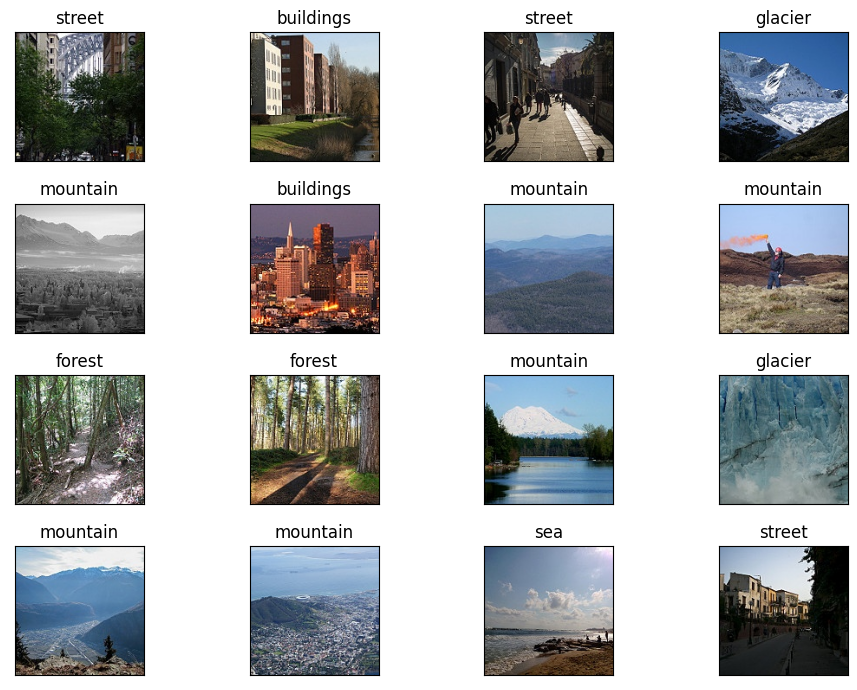

In [7]:
# vẽ các ảnh tương ứng với label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

In [8]:
data.Labels.value_counts()

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: Labels, dtype: int64

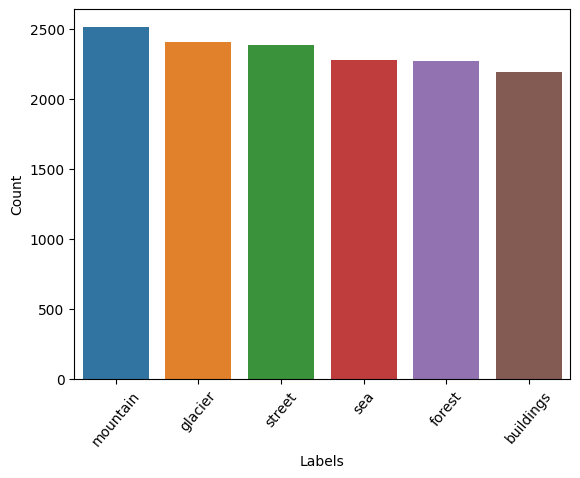

In [9]:
# Thống kê số lượng ảnh cho từng label 
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [10]:
batch_size = 32
img_height = 112
img_width = 112

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory= os.path.join(SCENES_CLASSIFICATION_PATH, 'train'),
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.


2022-12-29 15:37:12.259840: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 15:37:12.260293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:37:12.260395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:37:12.260442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=os.path.join(SCENES_CLASSIFICATION_PATH, 'val'),
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.


In [13]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


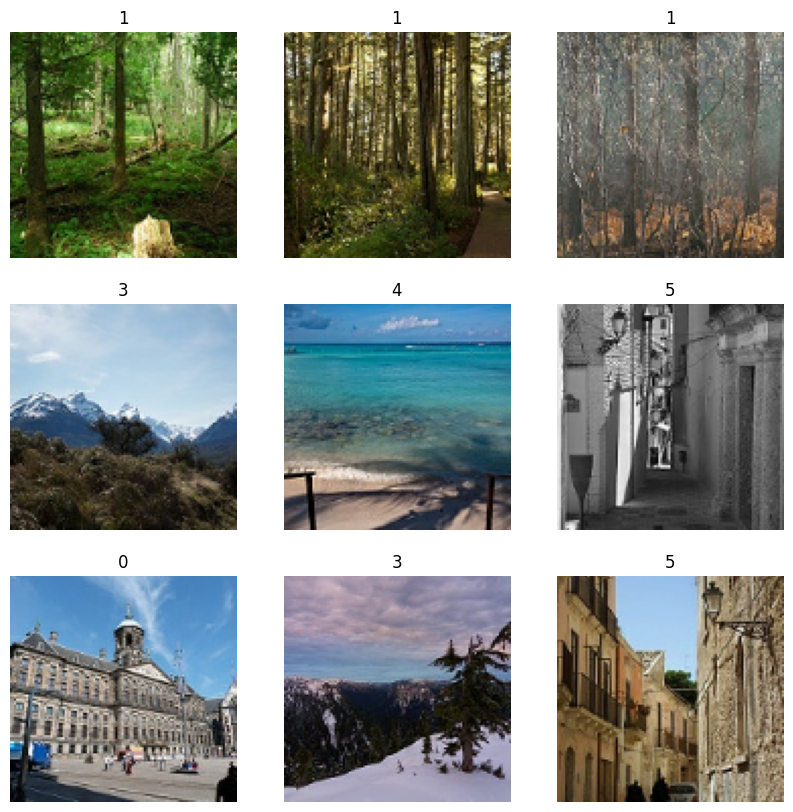

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(scale=1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)
                                        , fill_mode='nearest'),
])

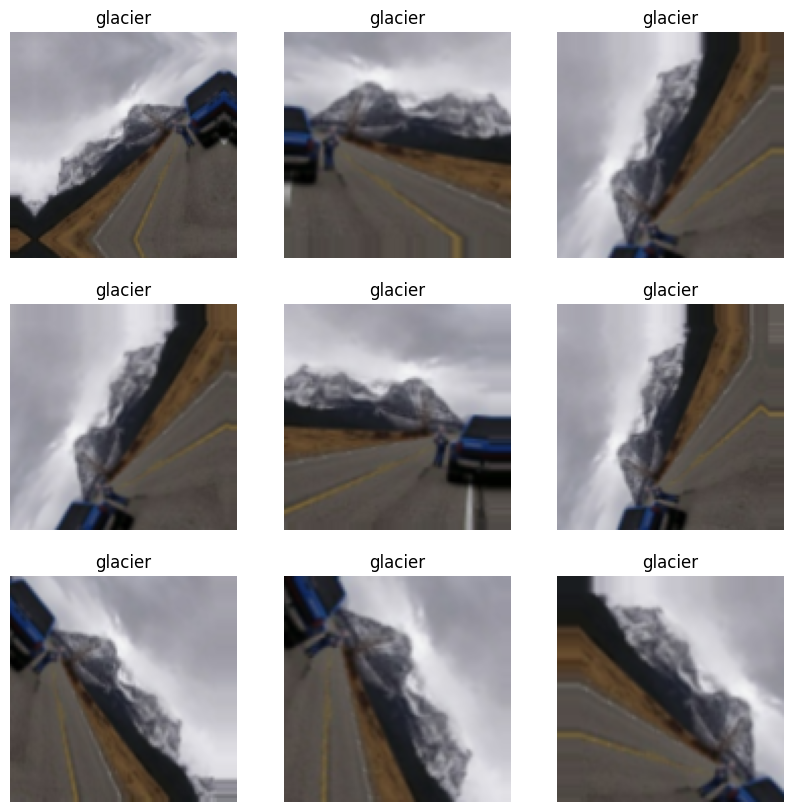

In [16]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

## DenseNet121 (skip connection: Concat)

In [17]:
class BuildDensenet121():
    def __init__(self):
        pass
    
    
    def conv_block(self, inputs, k=32):
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=4*k, kernel_size=(1,1), use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=k, kernel_size=(3,3), padding='same', use_bias=False)(x)
        
        skip_connection = layers.Concatenate(axis=-1)([inputs,x])
        
        return skip_connection
    
    
    def dense_block(self, x, nums_block, k=32):
        for i in range(nums_block):
            x = self.conv_block(x, 32)
        return x
        
    
    
    def trasition_layer(self, inputs, fraction=0.5):
        channels = inputs.shape[-1]
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=fraction*channels, kernel_size=(1,1), use_bias=False)(x)
        x = layers.AveragePooling2D(2, strides=2)(x)
        
        return x
    
    def build_model(self, classes, input_shape=(224,224,3)):
        inputs = layers.Input(shape=input_shape)
        
        x = layers.ZeroPadding2D(padding=((3, 3)))(inputs)
        x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.ZeroPadding2D(padding=((1, 1)))(x)
        x = layers.MaxPooling2D(3, strides=2)(x)
        
        # 1-6
        x = self.dense_block(x, nums_block=6)
        x = self.trasition_layer(x)
        
        # 2-12
        x = self.dense_block(x, nums_block=12)
        x = self.trasition_layer(x)
        
        # 3-24
        x = self.dense_block(x, nums_block=24)
        x = self.trasition_layer(x)
        
        #4-16
        x = self.dense_block(x, nums_block=16)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        
        return model

In [18]:
build_densenet121 = BuildDensenet121()
densenet121_model = build_densenet121.build_model(input_shape=(img_height, img_width, 3), classes=6)

image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = densenet121_model(x)
scenes_classification_densenet121_model = Model(inputs=image_input, outputs=x)

scenes_classification_densenet121_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 3)       0         
                                                                 
 model (Functional)          (None, 6)                 7043654   
                                                                 
Total params: 7,043,654
Trainable params: 6,960,006
Non-trainable params: 83,648
_________________________________________________________________


In [19]:
num_epochs = 100

scenes_classification_densenet121_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


history = scenes_classification_densenet121_model.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds)

Epoch 1/100


2022-12-29 15:37:18.434382: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-12-29 15:37:19.523549: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


439/439 [==============================] - 29s 52ms/step - loss: 1.0905 - accuracy: 0.5837 - val_loss: 1.5708 - val_accuracy: 0.4260
Epoch 2/100
439/439 [==============================] - 22s 49ms/step - loss: 0.9222 - accuracy: 0.6489 - val_loss: 0.9481 - val_accuracy: 0.6480
Epoch 3/100
439/439 [==============================] - 22s 49ms/step - loss: 0.8311 - accuracy: 0.6908 - val_loss: 0.9285 - val_accuracy: 0.6567
Epoch 4/100
439/439 [==============================] - 22s 49ms/step - loss: 0.7664 - accuracy: 0.7162 - val_loss: 3.1575 - val_accuracy: 0.3260
Epoch 5/100
439/439 [==============================] - 22s 49ms/step - loss: 0.7284 - accuracy: 0.7315 - val_loss: 1.6849 - val_accuracy: 0.4873
Epoch 6/100
439/439 [==============================] - 22s 49ms/step - loss: 0.6910 - accuracy: 0.7466 - val_loss: 1.7837 - val_accuracy: 0.4250
Epoch 7/100
439/439 [==============================] - 21s 48ms/step - loss: 0.6678 - accuracy: 0.7546 - val_loss: 1.0463 - val_accuracy: 0.60

439/439 [==============================] - 21s 48ms/step - loss: 0.2189 - accuracy: 0.9214 - val_loss: 0.5991 - val_accuracy: 0.8087
Epoch 58/100
439/439 [==============================] - 22s 49ms/step - loss: 0.2242 - accuracy: 0.9200 - val_loss: 0.7221 - val_accuracy: 0.7853
Epoch 59/100
439/439 [==============================] - 22s 49ms/step - loss: 0.2266 - accuracy: 0.9173 - val_loss: 0.8584 - val_accuracy: 0.7520
Epoch 60/100
439/439 [==============================] - 22s 50ms/step - loss: 0.2168 - accuracy: 0.9183 - val_loss: 0.8001 - val_accuracy: 0.7703
Epoch 61/100
439/439 [==============================] - 21s 49ms/step - loss: 0.2068 - accuracy: 0.9237 - val_loss: 0.7139 - val_accuracy: 0.7907
Epoch 62/100
439/439 [==============================] - 21s 47ms/step - loss: 0.2183 - accuracy: 0.9204 - val_loss: 0.7533 - val_accuracy: 0.7743
Epoch 63/100
439/439 [==============================] - 21s 48ms/step - loss: 0.2075 - accuracy: 0.9231 - val_loss: 0.9197 - val_accuracy

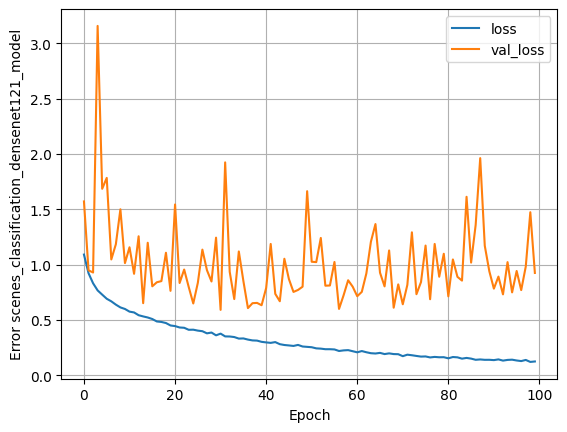

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error scenes_classification_densenet121_model')
plt.legend()
plt.grid(True)

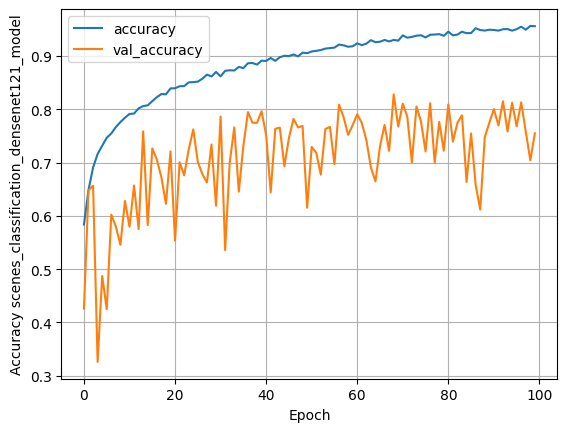

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy scenes_classification_densenet121_model')
plt.legend()
plt.grid(True)

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,0.132986,0.950264,0.942286,0.768000,95
96,0.127650,0.954966,0.769258,0.813000,96
97,0.137934,0.949266,0.981762,0.758333,97
98,0.120016,0.956392,1.473279,0.704333,98
99,0.124082,0.955893,0.924409,0.755000,99
